以下の論文と同じデータを活用して、実際の問題に深層学習を適用してみます。

Kraus, O. Z., Grys, B. T., Ba, J., Chong, Y., Frey, B. J., Boone, C., & Andrews, B. J. (2017). Automated analysis of high-content microscopy data with deep learning. Molecular Systems Biology, 13(4), 924. https://doi.org/10.15252/msb.20177551

この論文では酵母細胞の顕微鏡画像による標的タンパク質の細胞内の局在部位を予測するタスクに取り組んでいます。このnotebookではこの論文のデータを用いて同様のタスクの予測を行うモデルを学習してみます。
この論文ではいくつかのデータを扱っていますが、今回は `Chong_*_set.hdf5`のデータを使います。このデータは64x64の2 channelの画像と細胞内のどこに局在しているかを示す19種類のラベルが付いているデータになっています。19種類のラベルは以下の通りです。
```
'ACTIN', 'BUDNECK', 'BUDTIP', 'CELLPERIPHERY', 'CYTOPLASM', 'ENDOSOME', 'ER', 'GOLGI', 'MITOCHONDRIA', 'NUCLEARPERIPHERY', 'NUCLEI', 'NUCLEOLUS', 'PEROXISOME', 'SPINDLE', 'SPINDLEPOLE', 'VACUOLARMEMBRANE', 'VACUOLE','DEAD','GHOST'
```

これはMNISTと同じ画像分類（Image Classification）というタスクであるため、MNISTと同様の流れでモデルを学習することができます。

## 環境構築

まず環境構築のためColab上で以下のセルを実行してChainer, CuPy, ChainerCV, matplotlibといったPythonパッケージのインストールする。

In [0]:
# Install Chainer and CuPy!
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   6101      0 --:--:-- --:--:-- --:--:--  6128
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


環境セットアップができたか確認してみます。

In [0]:
import chainer

chainer.print_runtime_info()

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: 2.0.0.post3


次に、データ・セットをダウンロードし、解凍します。

In [0]:
!wget http://spidey.ccbr.utoronto.ca/~okraus/DeepLoc_full_datasets.zip
!unzip DeepLoc_full_datasets.zip

--2019-01-11 00:42:27--  http://spidey.ccbr.utoronto.ca/~okraus/DeepLoc_full_datasets.zip
Resolving spidey.ccbr.utoronto.ca (spidey.ccbr.utoronto.ca)... 142.150.52.198
Connecting to spidey.ccbr.utoronto.ca (spidey.ccbr.utoronto.ca)|142.150.52.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 597994029 (570M) [application/zip]
Saving to: ‘DeepLoc_full_datasets.zip’

DeepLoc_full_datase 100%[===================>] 570.29M  32.8MB/s    in 18s     

2019-01-11 00:42:45 (31.8 MB/s) - ‘DeepLoc_full_datasets.zip’ saved [597994029/597994029]

Archive:  DeepLoc_full_datasets.zip
   creating: datasets/
  inflating: datasets/wt2017_test_set.hdf5  
  inflating: datasets/wt2017_train_set.hdf5  
  inflating: datasets/Schuldiner_train_set.hdf5  
  inflating: datasets/Schuldiner_test_set.hdf5  
  inflating: datasets/Chong_train_set.hdf5  
  inflating: datasets/Chong_valid_set.hdf5  
  inflating: datasets/README.TXT     
  inflating: datasets/Chong_test_set.hdf5  


解凍したデータセットの中身を確認していきます。

In [0]:
!ls ./datasets

Chong_test_set.hdf5   README.TXT		 wt2017_test_set.hdf5
Chong_train_set.hdf5  Schuldiner_test_set.hdf5	 wt2017_train_set.hdf5
Chong_valid_set.hdf5  Schuldiner_train_set.hdf5


今回はこのうち `Chong_*_set.hdf5` のファイルを使っていきます。
hdf5ファイルなので、どのような構成になっているか開いて確認していきます。

In [0]:
!pip install h5py

import h5py

with h5py.File('./datasets/Chong_train_set.hdf5','r') as f:
    for key in f.keys():
        print(key,f[key])

Index1 <HDF5 dataset "Index1": shape (21882, 19), type "|i1">
Info1 <HDF5 dataset "Info1": shape (21882, 317), type "<f8">
data1 <HDF5 dataset "data1": shape (21882, 8192), type "<f4">
label_names <HDF5 dataset "label_names": shape (21882,), type "|S16">


配布されているデータセットのREADMEを読むと、`data1` に画像データが、`Index1` にラベル情報がそれぞれ保存されているようです。実際の画像データを取り出してどのようなデータになっているか確認していきます。

In [0]:
import numpy  as np
with h5py.File('./datasets/Chong_train_set.hdf5','r') as f:
    data1 = f['data1'][:]
    print('data1 shape:', data1.shape)

data1 shape: (21882, 8192)


`data1.shape[0]`がデータ数、`data1.shape[1]`が画像のチャネル数x縦x横を表しています。
次に画素の分布がどのようになっているか確認します

min 0.0
max 255.0
mean 17.492313
median 10.0


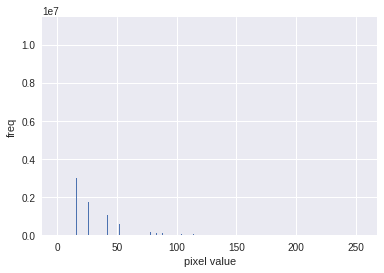

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

a = data1.flatten()
print('min', a.min())
print('max', a.max())
print('mean', a.mean())
print('median', np.median(a))

plt.hist(data1.flatten(), bins='auto')
plt.xlabel('pixel value')
plt.ylabel('freq')
plt.show()

次に一つ分の画像データを取り出して、分布を見てみます。画像はチャネル数x縦x横が1次元に潰れている状態であるため、`np.reshape()`によって元に戻します。

channel: 0
min [[ 9. 10. 10. ... 37. 36. 24.]
 [ 6.  7.  9. ... 39. 26. 24.]
 [ 6.  7.  9. ... 32. 28. 24.]
 ...
 [ 7.  6.  8. ...  7.  6.  7.]
 [ 6.  6.  8. ...  6.  6.  7.]
 [ 6.  6.  8. ...  5.  6.  6.]]
max 62.0
mean 12.01416
median 9.0


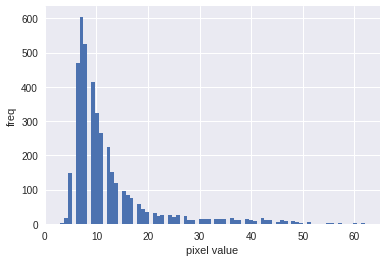

channel: 1
min [[11. 12. 14. ... 26. 19. 22.]
 [12. 11. 13. ... 24. 22. 20.]
 [11. 10.  9. ... 25. 23. 22.]
 ...
 [ 8.  7.  4. ...  7.  9.  8.]
 [ 6.  7.  6. ...  6.  7.  7.]
 [ 6.  7.  6. ...  5.  5.  7.]]
max 37.0
mean 14.299561
median 11.0


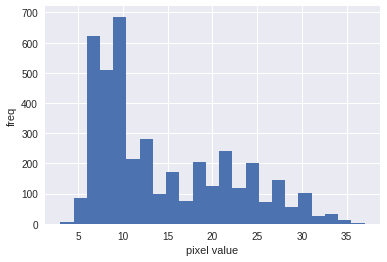

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

image= np.reshape(data1[0], (2, 64, 64))
for c in range(2):
    print('channel:', c)
    print('min', image[c])
    print('max', image[c].max())
    print('mean', image[c].mean())
    print('median', np.median(image[c]))

    plt.hist(image[c].flatten(), bins='auto')
    plt.xlabel('pixel value')
    plt.ylabel('freq')
    plt.show()

それでは実際に画像として表示させてみます。まずは各channelを別々に表示します。

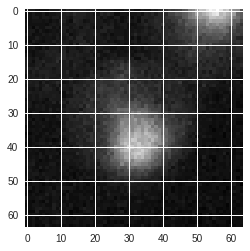

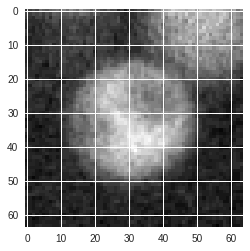

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

image= np.reshape(data1[0], (2, 64, 64))
plt.imshow(image[0, :, :], cmap='gray')
plt.show()

plt.imshow(image[1, :, :], cmap='gray')
plt.show()

次にRBG画像として表示します。RBG画像に変換するには `(heigh, width, 3)` のようにchannl数が3となる配列に変換します。今回はRとGに対応するchannelしかないため、Bには0を代入して表示します。

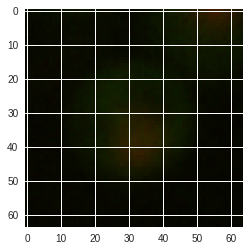

In [0]:
rgb_image = np.zeros((64, 64, 3))
rgb_image[: , :, 0] = image[0] 
rgb_image[: , :, 1] = image[1] 
rgb_image[: , :, 2] = 0

rgb_image = rgb_image.astype(np.uint8)
plt.imshow(rgb_image)
plt.show()

matplotlibはグレー画像は値を`[0, 255]`の範囲になるように自動で補正が入るのですが、RGB画像の場合はそのまま出力されるので暗い画像になっています。

次に対応するラベルのデータについても確認します。ラベル名は `label_names` にも保存されています。まずはこちらを確認してみます。

In [0]:
import numpy  as np
with h5py.File('./datasets/Chong_train_set.hdf5','r') as f:
  data1 = f['label_names']
  v = data1[0]
v

b'NUCLEI'

このため、先ほどの画像には'NUCLEI'というラベルが付いていることがわかります。
次に対応する`Index1`のデータについても確認します。

In [0]:
import numpy  as np
with h5py.File('./datasets/Chong_train_set.hdf5','r') as f:
  data1 = f['Index1']
  v = data1[0]
v

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int8)

データを表示させてみるとone hot ベクトルになっていることがわかります。
one hotベクトルはカテゴリデータを扱うときに用いられる手法の一つで、ラベルに対応する位置のみ１にし、残りを０にしたベクトルになります。
今回の場合では各位置が以下のラベルに対応してます。
```
'ACTIN', 'BUDNECK', 'BUDTIP', 'CELLPERIPHERY', 'CYTOPLASM', 'ENDOSOME', 'ER', 'GOLGI', 'MITOCHONDRIA', 'NUCLEARPERIPHERY', 'NUCLEI', 'NUCLEOLUS', 'PEROXISOME', 'SPINDLE', 'SPINDLEPOLE', 'VACUOLARMEMBRANE', 'VACUOLE','DEAD','GHOST'
```

'NUCLEI' はone hotベクトルで11番目にあります。このため、11番目が１で、残りは0というベクトルが'NUCLEI'を表すone hot ベクトルとなります。

次に各ラベルでどれくらいのデータ数があるのかも見ておきます。

In [0]:
with h5py.File('./datasets/Chong_train_set.hdf5','r') as f:
  data1 = f['label_names']
  unique, counts = np.unique(data1, return_counts=True)
dict(zip(unique, counts))

{b'ACTIN': 738,
 b'BUDNECK': 535,
 b'BUDTIP': 336,
 b'CELLPERIPHERY': 423,
 b'CYTOPLASM': 1500,
 b'DEAD': 749,
 b'ENDOSOME': 1500,
 b'ER': 1500,
 b'GHOST': 1428,
 b'GOLGI': 1500,
 b'MITOCHONDRIA': 1500,
 b'NUCLEARPERIPHERY': 1500,
 b'NUCLEI': 1500,
 b'NUCLEOLUS': 1500,
 b'PEROXISOME': 988,
 b'SPINDLE': 185,
 b'SPINDLEPOLE': 1500,
 b'VACUOLARMEMBRANE': 1500,
 b'VACUOLE': 1500}

ここからわかる通り、多いクラスでは1500データある一方、`BUDTIP`は336です。とりあえず、極端に少ないわけではないので、今回はこのまま学習させていきます。

まずはデータを管理する`Dataset`を用意します。`Dataset`は以下の2つの方法で用意します。

1. Chainerが標準で用意している`Dataset`classが扱えるデータ形式に変換し、標準の`Dataset`を使う。
2. Chainerの`DatasetMixin`classを使い、データの形式に合わせた独自の`Dataset`classを作る。

今回は汎用性の高い2つ目の方法を使って`Dataset` を用意します。

In [0]:
import chainer
import numpy as np
import h5py

class MicroscopyDataset(chainer.dataset.DatasetMixin):
  
    def __init__(self, h5_path):
        self.h5_data = h5py.File(h5_path,'r')
        self.label_key = 'Index1'
        self.data_key = 'data1'
        self.length = self.h5_data[self.data_key].shape[0]
        
    def __len__(self):
        return self.length
      
    def _get_image(self, i):
        img = self.h5_data[self.data_key][i]
        img = np.reshape(img, (2, 64, 64))
        return img
      
    def _get_label(self, i):
        one_hot_label = self.h5_data[self.label_key][i]
        label = one_hot_label.argmax() # labelのidを取得する
        return label

    def get_example(self, i):
        img = self._get_image(i)
        label = self._get_label(i)
        return img, label

実際にデータが読み込みできているか確認します。

In [0]:
train_dataset =  MicroscopyDataset('./datasets/Chong_train_set.hdf5')
val_dataset = MicroscopyDataset('./datasets/Chong_valid_set.hdf5')

print('train data size', len(train_dataset))
print('val data size', len(val_dataset))

train data size 21882
val data size 4491


In [0]:
image, label = train_dataset[0]
print('train image[0]', image)
print('train label[0]', label)

train image[0] [[[ 9. 10. 10. ... 37. 36. 24.]
  [ 6.  7.  9. ... 39. 26. 24.]
  [ 6.  7.  9. ... 32. 28. 24.]
  ...
  [ 7.  6.  8. ...  7.  6.  7.]
  [ 6.  6.  8. ...  6.  6.  7.]
  [ 6.  6.  8. ...  5.  6.  6.]]

 [[11. 12. 14. ... 26. 19. 22.]
  [12. 11. 13. ... 24. 22. 20.]
  [11. 10.  9. ... 25. 23. 22.]
  ...
  [ 8.  7.  4. ...  7.  9.  8.]
  [ 6.  7.  6. ...  6.  7.  7.]
  [ 6.  7.  6. ...  5.  5.  7.]]]
train label[0] 10


次に学習するモデルを用意します。まずはMNISTと同様に３層のMLPを用います。

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # パラメータを持つ層の登録
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(None, n_mid_units)
            self.l3=L.Linear(None, n_out)


    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

n_classes = 19
gpu_id = -1 # change to -1 if not using GPU
model = MLP(n_out=n_classes)
classifier = L.Classifier(model) # softmx cross entropyをloss関数として使用
if gpu_id >= 0:
    classifier.to_gpu(gpu_id)

`Dataset`とモデルができたら、あとはMNISTの学習のときと同様に`Trainer`クラスで使うものを用意します。

In [0]:
from chainer import iterators

batchsize = 128
train_iter = iterators.SerialIterator(train_dataset, batchsize)
val_iter = iterators.SerialIterator(val_dataset, batchsize,
                                     repeat=False, shuffle=False)

In [0]:
from chainer import optimizers

optimizer = optimizers.Adam()
optimizer.setup(classifier)

In [0]:
from chainer import training
from chainer.training import extensions

# Set up a trainer
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)
trainer = training.Trainer(updater, (20, 'epoch'), out='result')

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(val_iter, classifier, device=gpu_id))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time', 'lr']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# Run the training
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time  lr        
     total [#.................................................]  2.92%
this epoch [#############################.....................] 58.50%
       100 iter, 0 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           10.7601     3.00914               0.202166       0.26235                   29.1707                   
     total [##................................................]  5.85%
this epoch [########..........................................] 16.99%
       200 iter, 1 epoch / 20 epochs
    5.2606 iters/sec. Estimated time to finish: 0:10:11.923258.
     total [####..............................................]  8.77%
this epoch [#####################################.............] 75.49%
       300 iter, 1 epoch / 20 epochs
    5.9487 iters/sec. Estimated time to finish: 0:08:44.327783.
2           3.03524     2.83149               0.2796

学習したモデルがどのような構造になっているのか確認します。

In [0]:
!dot -Tpng result/cg.dot -o result/cg.png

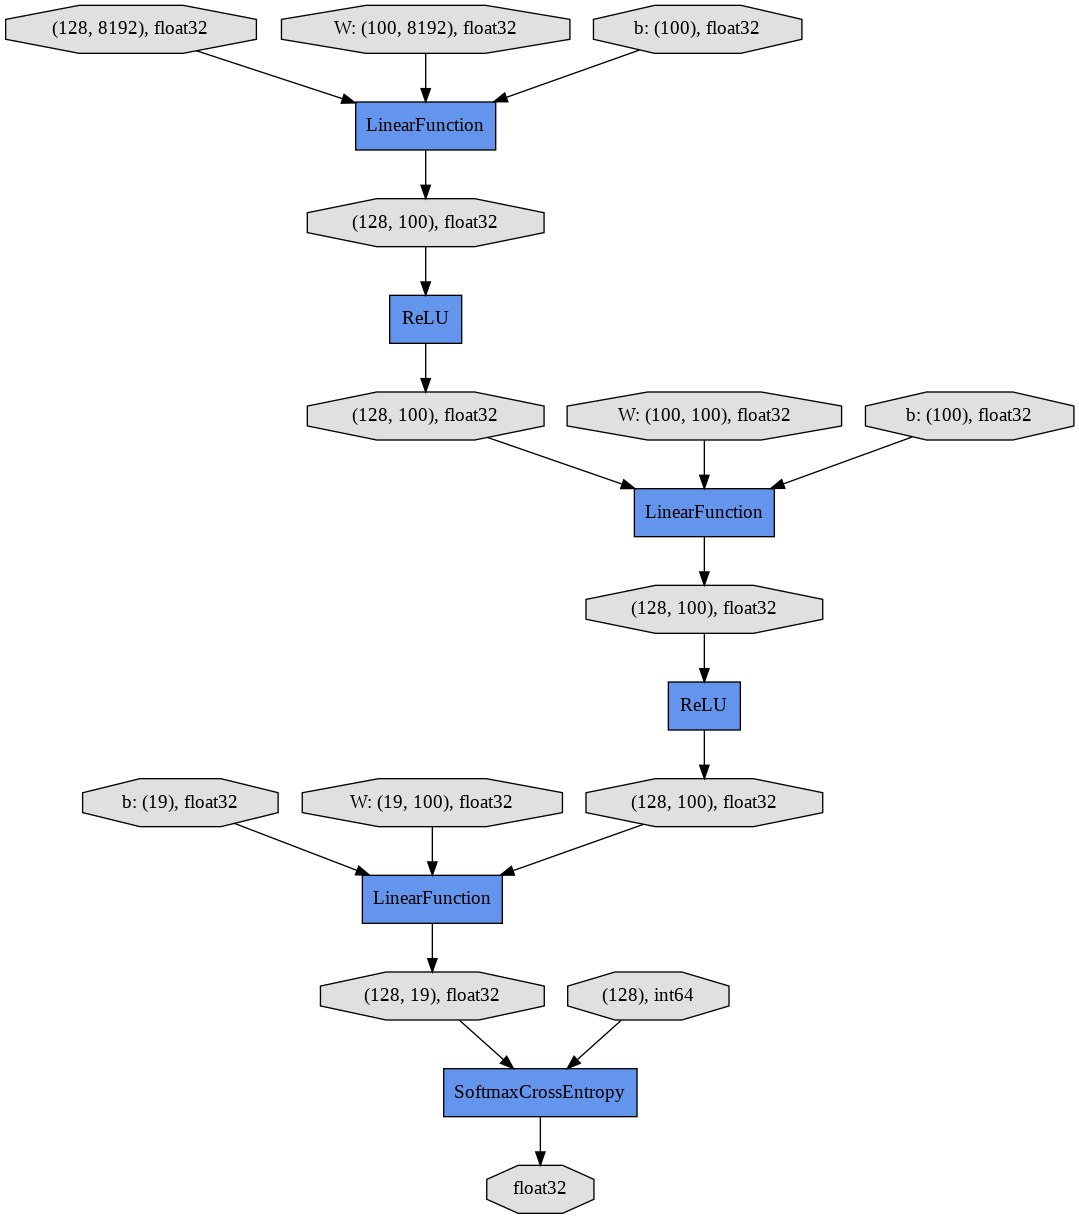

In [0]:
from IPython.display import Image
Image(filename='result/cg.png')

また、logで出ていたlossとaccuracyがどのように変化していたのか、グラフでも確認します

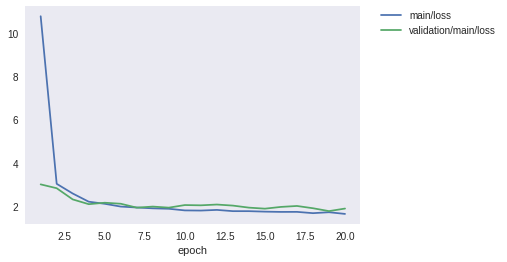

In [0]:
from IPython.display import Image
Image(filename='result/loss.png')

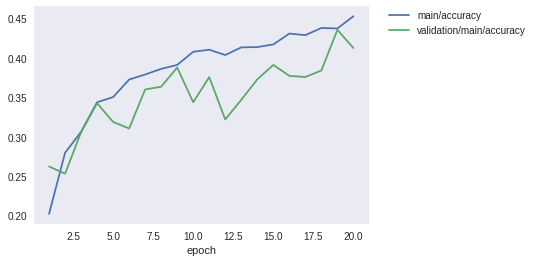

In [0]:
from IPython.display import Image
Image(filename='result/accuracy.png')

学習ができたら、できたモデルを使って予測をしてみます。
まず、できたモデルを保存します。

In [0]:
from chainer import serializers

serializers.save_npz('my_model.npz', model)

# ちゃんと保存されていることを確認
%ls -la ./my_model.npz

-rw-r--r-- 1 root root 3071876 Jan 11 00:54 ./my_model.npz


次に、保存されたモデルを読み込んで予測させてみます。

In [0]:
# まず同じモデルのオブジェクトを作る
infer_model = MLP(n_out=n_classes)

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_model.npz', infer_model)

# GPU上で計算させるために、モデルをGPUに送る
if gpu_id >= 0:
    infer_model.to_gpu(gpu_id)

In [0]:
from chainer.cuda import to_gpu, to_cpu

# ミニバッチの形にする（ここではサイズ1のミニバッチにするが、
# 複数まとめてサイズnのミニバッチにしてまとめて推論することもできる）
x_val, y_val = val_dataset[0]
print(x_val.shape, end=' -> ')
x_val = x_val[None, ...]
print(x_val.shape)

# GPU上で計算させるため、データもGPU上に送る
if gpu_id >= 0:
    xx_val= to_gpu(x_val, 0)

# モデルのforward関数に渡す
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    pred_y = infer_model(x_val)

# Variable形式で出てくるので中身を取り出す
pred_y = pred_y.data

# 結果をCPUに送る
pred_y = to_cpu(pred_y)

# 最大値のインデックスを見る
pred_label = pred_y.argmax(axis=1)

print('predicted label:', pred_label[0])
print('ground truth:', y_val)

(2, 64, 64) -> (1, 2, 64, 64)
predicted label: 8
ground truth: 8


## 応用編：精度の高い学習を目指して改良

まずは今回のデータを使ってChainerで簡単なモデルを学習しました。
結果からわかるとおり、精度としては非常に低いため、まだまだ改良が必要です。
ここからはこのデータセットに合わせていろいろ改良を加えて精度を上げていくことを目指します。
ここでは以下の4つのことを行い精度を上げてみます。

1. data augmentation
2. より大きなモデルの利用
3. loss関数の変更
4. Adamのalphaのスケジューリング

まず、Chainerの画像処理部分に特化した関数を用意しているChainerCVをインストールします。

In [0]:
!pip install chainercv

    100% |████████████████████████████████| 225kB 15.6MB/s 
  Running setup.py bdist_wheel for chainercv ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/95/24/5a/1611db416857b5e092962bc22a70722315881e03970c7fa966
Successfully built chainercv


### データの正規化とData Augmentaion

最初に画像の分布を見てわかる通り、１つの画像の画素値と画像すべての画素値の分布が大きく違うことがわかります。
このため、何らかの正規化をしたほうが良いと考えられます。
ここでは、論文の筆者らの実装を参考に、各画像の画素値の0.1%と99.9%の値を最小、最大とし、0-1の値に正規化します。

また、これに加えて、深層学習でよく使われるdata augmentationを入れます。data augmentationは入力にランダムな変換を加えることで、データの水増しを行うことです。今回は論文の筆者らが使っていたランダムに画像の一部と取り出してくるRandom Cropを使います。

trainのdataにRandom Cropを施す関係上、validation用のデータには画像の中心を取り出してくるようにします。
このデータの正規化とData Augmentaionを行う関数として`transform_train`と`transform_val`を用意して、データにアクセスしたとき、自動的にこれらの関数が適用される`TransformDataset`を使って新しいデータセットを作ります。

In [0]:
import chainercv


def normalize(image, min_values, max_values):
    for c_i in range(len(min_values)): # channel毎に正規化
        image[c_i, image[c_i] > max_values[c_i]] = max_values[c_i]
        image[c_i] -= min_values[c_i]
        image[c_i] /= np.float32(max_values[c_i] - min_values[c_i])
    return image


def transform_train(in_data):
    image, label = in_data
    min_values = np.percentile(image, 0.1, axis=(1,2))
    max_values = np.percentile(image,  99.9, axis=(1,2))
    image = normalize(image, min_values, max_values)
    image = chainercv.transforms.random_crop(image, (60, 60))
    return image, label


def transform_val(in_data):
    image, label = in_data
    min_values = np.percentile(image, 0.1, axis=(1,2))
    max_values = np.percentile(image,  99.9, axis=(1,2))
    image = normalize(image, min_values, max_values)
    image = chainercv.transforms.center_crop(image, (60, 60))
    return image, label


train_dataset =  MicroscopyDataset('./datasets/Chong_train_set.hdf5')
train_dataset_wit_augmentation = chainer.datasets.TransformDataset(train_dataset, transform_train)
val_dataset = MicroscopyDataset('./datasets/Chong_valid_set.hdf5')
val_dataset_wit_augmentation = chainer.datasets.TransformDataset(val_dataset, transform_val)

実際にこのデータセットを使った場合の結果を見てみます。

In [0]:
image, label = train_dataset[0]
print('default')
print('train image[0]', image)
print('train label[0]', label)
print('')

image, label = train_dataset_wit_augmentation[0]
print('wit augmentation')
print('train image[0]', image)
print('train label[0]', label)

default
train image[0] [[[ 9. 10. 10. ... 37. 36. 24.]
  [ 6.  7.  9. ... 39. 26. 24.]
  [ 6.  7.  9. ... 32. 28. 24.]
  ...
  [ 7.  6.  8. ...  7.  6.  7.]
  [ 6.  6.  8. ...  6.  6.  7.]
  [ 6.  6.  8. ...  5.  6.  6.]]

 [[11. 12. 14. ... 26. 19. 22.]
  [12. 11. 13. ... 24. 22. 20.]
  [11. 10.  9. ... 25. 23. 22.]
  ...
  [ 8.  7.  4. ...  7.  9.  8.]
  [ 6.  7.  6. ...  6.  7.  7.]
  [ 6.  7.  6. ...  5.  5.  7.]]]
train label[0] 10

wit augmentation
train image[0] [[[0.07706387 0.0577979  0.0577979  ... 0.7128408  0.63577694 0.6165109 ]
  [0.0577979  0.0577979  0.09632984 ... 0.7128408  0.67430884 0.42385128]
  [0.09632984 0.0577979  0.09632984 ... 0.63577694 0.53944707 0.4623832 ]
  ...
  [0.07706387 0.0577979  0.07706387 ... 0.0577979  0.03853193 0.01926597]
  [0.09632984 0.1155958  0.07706387 ... 0.0577979  0.01926597 0.03853193]
  [0.1155958  0.03853193 0.03853193 ... 0.03853193 0.0577979  0.03853193]]

 [[0.2580645  0.4516129  0.38709676 ... 0.6451613  0.7096774  0.48387095]


### loss関数の変更

最初の例では一般的なimage classificationで用いられるsoftmax cross entropyをlossとして用いました。
ここでは、論文の実装で用いられていたsigmodi cross entorpyを使ってみます。
これを使うにあたり、labelはone hot ベクトルにする必要があるため、以下のようなloss関数用のクラスを定義して使います。

In [0]:
from chainer import backend
import chainer.functions as F

class LossFunction(object):
    
    def __init__(self):
        self.class_one_hot = None
    
    def __call__(self, y, t):
        xp = backend.get_array_module(y)
        if self.class_one_hot is None: # one hot ベクトル用の行列を初期化
            n_classes = y.shape[1]
            self.class_one_hot = xp.identity(n_classes, dtype=xp.int32)                                                                                                                                                                                                                                                   
        t_one_hot = self.class_one_hot[t] # tに対するone hotベクトルを取得
        loss = F.sigmoid_cross_entropy(y, t_one_hot) # sigmoid cross entorpyを使用
        return loss

### より大きなモデルの利用

最初の例では学習を簡単にするために小さいモデルを使っていました。ただし、これでは高い精度が得られない場合があります。
このため、ここでは一般的なimage classificationで用いられるモデルの一つであるResNet50を使ってみます。

In [0]:
import chainer.links as L
from chainercv.links import ResNet50

model = ResNet50(n_class=n_classes)
classifier = L.Classifier(model, lossfun=LossFunction()) # loss関数を定義したものに置き換える
if gpu_id >= 0:
    classifier.to_gpu(gpu_id)

In [0]:
from chainer import iterators

batchsize = 128
train_iter = iterators.SerialIterator(train_dataset_wit_augmentation, batchsize)
val_iter = iterators.SerialIterator(val_dataset_wit_augmentation, batchsize,
                                     repeat=False, shuffle=False)

In [0]:
from chainer import optimizers

optimizer = optimizers.Adam()
optimizer.setup(classifier)

In [0]:
from chainer import training
from chainer.training import extensions

# Set up a trainer
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)
trainer = training.Trainer(updater, (20, 'epoch'), out='result')

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(val_iter, classifier, device=gpu_id))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time', 'lr']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

### Adamのalphaのスケジューリング

最初の例では`alpha`は変更せずにそのまま使っていましたが、論文の実装と同様にAdamのパラメータの一つである `alpha` を徐々に小さくさせていきます。ここでは25 iterationごとに0.96をかけていくことで`alpha` を徐々に小さくしていきます。

In [0]:
from chainer import training
from chainer.training import extensions


trainer.extend(extensions.ExponentialShift('alpha', 0.96, init=None, target=None, optimizer=None), trigger=(25, 'iteration'))
trainer.extend(extensions.observe_lr(observation_key='lr'))

In [0]:
trainer.run()

４つの変更を加えたことで、最初の例のときよりも高い精度に到達できました。